<a href="https://colab.research.google.com/github/Birkbeck/msc-projects-2023-4-Gabriele_Monti_PEFT/blob/main/01_Adapter_Training_summarisation_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In tthis  Colab notebook, I have attempted to fine-tune BART using adapter training, where the adapter is a smaller neural network integrated into BART's output layer. Two types of adapters: a bottleneck adapter and a LoRA (Low-Rank Adaptation) adapter. Despite your efforts, the model struggles to produce satisfactory results, either due to overfitting or failing to effectively learn the task. A deeper analysis is necessary to address these issues.

In [1]:
!pip install -qq adapters
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.0/263.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency 

In [ ]:
#load and check the dataset
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

dataset.num_rows

{'train': 287113, 'validation': 13368, 'test': 11490}

In [ ]:
dataset['train'][0]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [2]:
#use only a portion of the dataset as it is very large
from datasets import load_dataset, DatasetDict

# Load the first 10% of the training data
small_train_dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:7%]")

# Decide on the split sizes
train_size = 0.8  # 80% of the data for training
valid_size = 0.2  # Remaining 20% for validation

# Split the dataset
train_valid_split = small_train_dataset.train_test_split(test_size=valid_size)

# Organize the splits in a new DatasetDict for convenience
split_dataset = DatasetDict({
    'train': train_valid_split['train'],
    'validation': train_valid_split['test']
})

# Verify the sizes of the splits
print(f"Training set size: {len(split_dataset['train'])}")
print(f"Validation set size: {len(split_dataset['validation'])}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Training set size: 16078
Validation set size: 4020


In [3]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11484
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 2872
    })
})

In [ ]:
split_dataset['train'][0]

{'article': '(CNN) -- What do Conan O\'Brien, Etsy.com and the Smurfs all have in common? They are part of the hottest craft trends for 2011, according to organizations like craftster.org, that track the $29.2 billion dollar craft and hobby industry in the U.S. An increase in handmade technology accessories and vintage patterns for clothes are popular, too, as art and craft enthusiasts find new ways to develop their creative talents. Hot trend: Conan . Conan O\'Brien is more than a late night talk show host, these days. He\'s credited with exposing a new and younger audience to artwork. Fans of the comedian have been inspired to create illustrations, paintings, mixed media, digital art and edibles that look like the late night star - and this work is sometimes showcased on his TBS television show and on his website. "While we had never actively solicited artwork or crafts from fans, we were seeing so much incredible stuff posted across the web, and were inspired to build \'Coco MoCA - 

In [4]:
encoded_subset = split_dataset.map(preprocess_data, batched = True)

Map:   0%|          | 0/22968 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/5743 [00:00<?, ? examples/s]

In [3]:
#data tokenisation routine

from transformers import AutoTokenizer

model_checkpoint = "facebook/bart-base"


tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
max_input_length = 128
max_target_length = 128

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
        padding="max_length"  # Ensure all sequences are padded to the same length
    )
    labels = tokenizer(
        examples["highlights"],
        max_length=max_target_length,
        truncation=True,
        padding="max_length"  # Ensure all sequences are padded to the same length
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [13]:
encoded_subset = split_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/16078 [00:00<?, ? examples/s]

Map:   0%|          | 0/4020 [00:00<?, ? examples/s]

In [6]:
#encoded_subset['train'][0]
encoded_subset


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 20672
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5168
    })
})

In [14]:
#load the adapter

from adapters import AutoAdapterModel
model = AutoAdapterModel.from_pretrained("facebook/bart-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
# Add a new adapter
model.add_adapter("cnn_dailymail", config="lora")#seq_bn
# Alternatively, e.g.:
# model.add_adapter("rotten_tomatoes", config="lora")

# Add a matching translation head
model.add_seq2seq_lm_head(
    "cnn_dailymail"
)
# Activate the adapter
model.train_adapter("cnn_dailymail")


In [8]:
# use ADAM if necessary
from transformers import Trainer, AdamW, get_linear_schedule_with_warmup # Import Trainer from transformers
# Initialize the AdamW optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(encoded_subset['train']) // 2 * 1  # Assuming n epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
#call back function to meause the loss during training
from transformers import TrainingArguments, TrainerCallback, EvalPrediction

# Custom Callback to Log Loss
class LossLoggingCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # This method is called whenever the logging step is reached.
        if logs is not None and 'loss' in logs:
            self.losses.append(logs['loss'])

loss_logging_callback = LossLoggingCallback()

In [19]:
#training script

import numpy as np
from transformers import TrainingArguments, EvalPrediction
from adapters import AdapterTrainer
import torch

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

training_args = TrainingArguments(
    learning_rate=5e-5,#1e-4
    num_train_epochs=2,
    per_device_train_batch_size=70,
    per_device_eval_batch_size=70,
    logging_steps=10,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
    weight_decay=0.01,
    #warmup_steps=500,
    gradient_accumulation_steps=4
)


trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_subset['train'],
    eval_dataset=encoded_subset['validation'],
    #optimizers=(optimizer, scheduler),  # Pass the custom optimizer and scheduler here
    callbacks=[loss_logging_callback]  # Add your custom callback here
)


trainer.train()

Step,Training Loss
10,21.489700
20,20.941500
30,20.268900
40,19.566700
50,18.923900
60,18.199800
70,17.699500
80,17.342700
90,17.036300
100,16.770200


TrainOutput(global_step=114, training_loss=18.548545837402344, metrics={'train_runtime': 376.162, 'train_samples_per_second': 85.484, 'train_steps_per_second': 0.303, 'total_flos': 2442008675745792.0, 'train_loss': 18.548545837402344, 'epoch': 1.982608695652174})

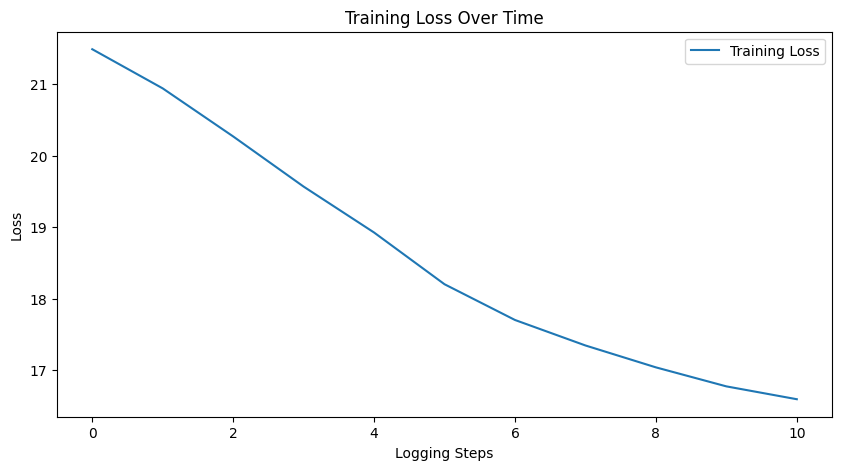

In [20]:
# Access the recorded losses after training and plot the result
losses = loss_logging_callback.losses

#Plot the losses using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()


It has been observed that the loss diminishes over time, indicating that the model is learning. However, despite numerous tests, the loss consistently decreases, but the actual outputs never achieve the desired results.

In [14]:
trainer.evaluate()

{'eval_loss': 16.761701583862305,
 'eval_runtime': 16.7676,
 'eval_samples_per_second': 171.283,
 'eval_steps_per_second': 5.367,
 'epoch': 0.9916434540389972}

The training loss is 18.55 after 114 steps, showing the model is learning. The evaluation loss is slightly lower at 16.76, indicating some improvement on new data. Both metrics suggest ongoing learning but also highlight areas for improvement.

In [ ]:
model

BartAdapterModel(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayerWithAdapters(
          (self_attn): BartSdpaAttentionWithAdapters(
            (k_proj): LoRALinearTorch(
              in_features=768, out_features=768, bias=True
              (loras): ModuleDict()
            )
            (v_proj): LoRALinearTorch(
              in_features=768, out_features=768, bias=True
              (loras): ModuleDict()
            )
            (q_proj): LoRALinearTorch(
              in_features=768, out_features=768, bias=True
              (loras): ModuleDict()
            )
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
            (prefix_tuning): PrefixTuningLayer(
              (prefix_gates): ModuleDict()
            

**BartAdapterModel Summary:**

The BartAdapterModel integrates adapters into both the encoder and decoder. Each has six layers with self-attention and FC layers using LoRALinearTorch. It includes Prefix Tuning with PrefixTuningLayer and PrefixTuningPool, and BottleneckLayer adapters for attention and output, featuring ReLU activation, adapter_down, and adapter_up layers. The model has specialized heads, such as Seq2SeqLMHead for tasks like cnn_dailymail.

In [25]:
text ='''summarize the following text: Amazon, the global e-commerce giant, has recently announced the launch of its highly anticipated Prime service, aiming to revolutionize the online shopping experience. Prime, which has already garnered significant attention, promises a host of benefits designed to enhance customer satisfaction and loyalty.

One of the most attractive features of Amazon Prime is its expedited shipping service. Prime members are eligible for free two-day shipping on millions of items, with some locations even offering same-day or one-day delivery. This feature is particularly beneficial for customers who need their purchases quickly, reducing the wait time significantly compared to standard shipping options.

In addition to fast and free shipping, Amazon Prime offers members access to a vast library of streaming content. Prime Video, the platform's streaming service, includes thousands of movies, TV shows, and exclusive content produced by Amazon Studios. This positions Prime as not just a shopping service but also a major player in the entertainment industry, competing with other streaming giants like Netflix and Hulu.

Another compelling feature of Amazon Prime is Prime Music, a streaming service that allows members to listen to over two million songs ad-free. This service is a direct competitor to other music streaming platforms like Spotify and Apple Music, offering curated playlists and personalized recommendations.

Prime members also benefit from exclusive access to early deals and discounts on a wide range of products during special events such as Prime Day. These events offer significant savings on popular items, making membership even more valuable for frequent shoppers.

Amazon has also introduced Prime Reading, which provides members with access to a rotating selection of books, magazines, and comics at no additional cost. This feature enhances the value of Prime membership for avid readers, offering a diverse array of reading material accessible from any device.

Moreover, Amazon Prime includes additional perks such as unlimited photo storage with Amazon Photos, which helps members securely store and organize their photos online. This feature adds another layer of value, especially for customers who frequently use digital photography.

The launch of Amazon Prime represents a significant step in Amazon's strategy to create a comprehensive and integrated service ecosystem. By bundling multiple services into a single membership, Amazon aims to increase customer retention and encourage more frequent use of its platform.

With its extensive range of benefits, Amazon Prime is poised to become an indispensable service for many consumers, offering unparalleled convenience and value. As the service continues to expand and evolve, it is expected to attract even more subscribers, further solidifying Amazon's position as a leader in the e-commerce and digital services industries.'''

In [24]:
text = "Former BBC news presenter Huw Edwards, who resigned in April on medical advice, saw his salary increase by £40,000 last year despite being suspended in July 2023 over allegations published in The Sun newspaper. Police found no evidence of a criminal offense. Edwards' salary rose from between £435,000 - £439,999 in 2022/2023 to £475,000 - £479,999 between April 2023 and April 2024. Gary Lineker remains the BBC's highest-paid star, earning around £1.35 million last year. The BBC's annual report also highlighted a reduction in the number of households paying the license fee and announced further job cuts."


In [26]:
from transformers import BartForConditionalGeneration, BartTokenizer

def summarize(text):
    inputs = tokenizer([text], max_length=512, truncation=True, padding="max_length", return_tensors="pt")
    inputs = inputs.to(device)
    summary_ids = model.generate(inputs.input_ids, max_length=128, num_beams=10,temperature=0.3, do_sample=True,early_stopping=True,)#num_beams=50,temperature=0.3, do_sample=True,early_stopping=True,
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

summary = summarize(text)
print(summary)


summarize the following text: Amazon, the global e-commerce giant, has recently announced the launch of its highly anticipated Prime service, aiming to revolutionize the online shopping experience. Prime, which has already garnered significant attention, promises a host of benefits designed to enhance customer satisfaction and loyalty.One of the most attractive features of Amazon Prime is its fast and free shipping. Prime members members are eligible for free two-day shipping on millions of items, with some locations even offering same-day or one-day delivery. This feature is particularly beneficial for customers who need their purchases quickly, reducing the wait time significantly compared to


The text above shows the summarization level, but in this case, it simply repeats the same content without providing a summary.


In [27]:
!pip install weightwatcher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 2.8 MB/s eta 0:00:00


In [28]:
import weightwatcher as ww

In [29]:
watcher = ww.WeightWatcher(model=model)

# Analyze the model
results = watcher.analyze()

summary = watcher.get_summary(results)
summary

{'log_norm': 3.4639937438858865,
 'alpha': 4.5876057138738595,
 'alpha_weighted': 7.682531269206155,
 'log_alpha_norm': 8.07232741848775,
 'log_spectral_norm': 1.791233390788407,
 'stable_rank': 56.20107315469585}

The metrics indicate that the model has a moderate overall magnitude (Log Norm), heavy-tailed behavior (Alpha, Alpha Weighted, Log Alpha Norm), good stability (Log Spectral Norm), and a high complexity or dimensionality (Stable Rank).